# Zestaw 7. Iteracyjne rozwiązywanie układów liniowych

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import networkx as nx

## 1. Metody stacjonarne

<i>Zaimplementuj metody Jacobiego, Gaussa-Seidla i SOR. Użyj ich do rozwiązania poniższych układów równań z dokładnością do 4 miejsc znaczących.</i>

In [ ]:
def non_zero_diagonal(A, B):
    n = A.shape[0]
    while not np.all(np.diag(A) != 0):
        zeros_columns = {}
        for i in range(n):
            if A[i][i] != 0: continue
            zeros_count = 0
            for j in range(n):
                if A[i][j] == 0:
                    zeros_count += 1
            
            zeros_columns[i] = zeros_count
        
        max_column = max(zeros_columns, key = zeros_columns.get)
        max_element_row = np.where(A[:, max_column] == max(A[:, max_column]))[0][0]

        A[[max_element_row, max_column]] = A[[max_column, max_element_row]]
        B[[max_element_row, max_column]] = B[[max_column, max_element_row]]
            
    return A, B

#### metoda Jacobiego

In [211]:
def jacobi(A, B, x0, exact, precision=1e-4):
    n = A.shape[0]
    
    A, B = non_zero_diagonal(A, B)
    
    x = x0
    D = np.diag(np.diag(A))
    inv_D = np.diag(1/np.diag(A))
    M = np.eye(n) - inv_D @ A
    W = inv_D @ B
    
    errors = []
    i = 0
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        print(errors[-1])
        x  = M @ x + W
        i += 1
        
        if i > 5000:
            raise Exception('iterations limit exceeded')
    
    errors.append(np.mean((abs(exact-x))))
    
    return i, x, errors

#### metoda Gaussa-Seidla

In [212]:
def gauss_seidl(A, B, x0, exact, precision=1e-4):
    n = A.shape[0]
    
    A, B = non_zero_diagonal(A, B)
    print(A)
    print(B)
    
    x = x0
    L = np.tril(A)
    print(L)
    
    U = np.triu(A) - np.diag(np.diag(A))
    M = -inv(L) @ U
    W = inv(L) @ B
    
    errors = []
    i = 0
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        print(errors[-1])
        x  = M @ x + W
        
        i += 1
        
        if i > 5000:
            raise Exception('iterations limit exceeded')
    
    errors.append(np.mean((abs(exact-x))))                  
    return i, x, errors

#### metoda SOR

In [213]:
def sor(A, B, x0, exact, omega, precision=1e-4):
    n = A.shape[0]
    
    A, B = non_zero_diagonal(A, B)
    
    x = x0
    D = np.diag(np.diag(A))
    L = np.tril(A) - D
    U = np.triu(A) - D
    M = inv(D + omega*L) @ (D - omega*(D + U))
    W = omega * inv(D + omega*L) @ B
    
    i = 0
    errors = []
    
    while not np.allclose(x, exact, atol=precision):
        errors.append(np.mean((abs(exact-x))))
        print(errors[-1])
        x  = M @ x + W
        
        i += 1
        if i > 5000:
            raise Exception('iterations limit exceeded')
    
    errors.append(np.mean((abs(exact-x))))
    
    return i, x, errors

#### testy

In [200]:
A1 = np.array([[7, 1, -1, 2], [1, 8, 0, -2],[-1, 0, 4, -1], [2, -2, -1, 6]])
B1 = np.array([3, -5, 4, -3])
x01 = np.zeros(4)
omega1 = 1.1
exact1 = np.array([1, -1, 1, -1])

In [201]:
A2 = np.array([[7, 3, -1, 2], [3, 8, 1, -4],[-1, 1, 4, -1], [2, -4, -1, 6]])
B2 = np.array([-1, 0, -3, 1])
x02 = np.zeros(4)
omega2 = 1.4
exact2 = np.array([-1, 1, -1, 1])

In [202]:
print("     jacobi: ", *jacobi(A1, B1, x01, exact1)[:-1])
print("gauss seidl: ", *gauss_seidl(A1, B1, x01, exact1)[:-1])
print("        sor: ", *sor(A1, B1, x01, exact1, omega1)[:-1])

1.0
0.36160714285714285
0.18154761904761904
0.09547725340136054
0.043916524943310636
0.023721104885406574
0.010868831659648026
0.005855707825310613
0.0026819057487058595
0.0014445018867155768
0.0006615489810915254
0.0003563060445562205
0.00016317922120787087
8.788698468470413e-05
     jacobi:  14 [ 0.99995716 -0.99995716  1.00000235 -0.99992703]
[[ 7  1 -1  2]
 [ 1  8  0 -2]
 [-1  0  4 -1]
 [ 2 -2 -1  6]]
[ 3 -5  4 -3]
[[ 7  0  0  0]
 [ 1  8  0  0]
 [-1  0  4  0]
 [ 2 -2 -1  6]]
gauss seidl:  7 [ 0.99989203 -0.99991255  1.00004696 -0.99992703]
        sor:  5 [ 1.00002942 -1.00002682  0.99996387 -1.00000953]


#### zależność błędu od numeru iteracji

<i>Zaprezentuj na wykresie zależność błędu od iteracji. Opisz i zinterpretuj wyniki. </i>

In [203]:
def plot_iteration_error(A, B, x0, exact, omega):
    jacobi_errors = jacobi(A, B, x0, exact)[2]
    gauss_seidl_errors = gauss_seidl(A, B, x0, exact)[2]
    sor_errors = sor(A, B, x0, exact, omega)[2]
    
    _, ax = plt.subplots(figsize=(12,8))
    
    ax.set_xlabel('iteration')
    ax.set_ylabel('error')
    
    ax.plot(list(range(len(jacobi_errors))), jacobi_errors, marker='o', label='jacobi', color='rosybrown', markersize=8)
    ax.plot(list(range(len(gauss_seidl_errors))), gauss_seidl_errors, marker='o', label='gauss-seidl', color='lightskyblue', markersize=8)
    ax.plot(list(range(len(sor_errors))), sor_errors, marker='o', label='sor', color='mediumaquamarine', markersize=8)
    
    plt.legend()
    plt.show()

1.0
0.36160714285714285
0.18154761904761904
0.09547725340136054
0.043916524943310636
0.023721104885406574
0.010868831659648026
0.005855707825310613
0.0026819057487058595
0.0014445018867155768
0.0006615489810915254
0.0003563060445562205
0.00016317922120787087
8.788698468470413e-05
[[ 7  1 -1  2]
 [ 1  8  0 -2]
 [-1  0  4 -1]
 [ 2 -2 -1  6]]
[ 3 -5  4 -3]
[[ 7  0  0  0]
 [ 1  8  0  0]
 [-1  0  4  0]
 [ 2 -2 -1  6]]


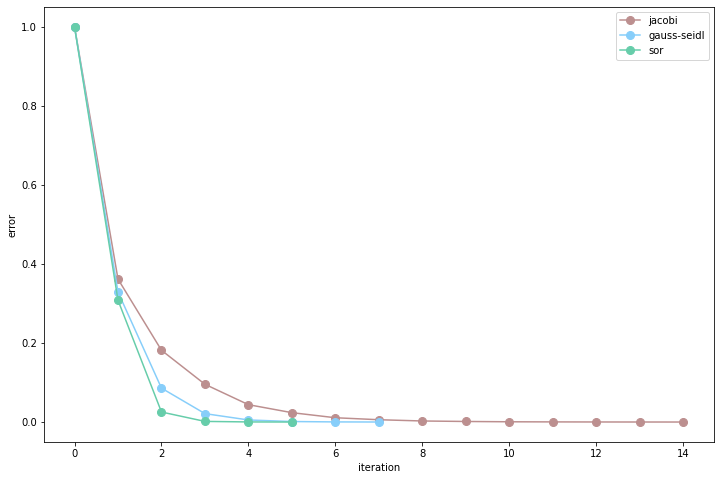

In [204]:
plot_iteration_error(A1, B1, x01, exact1, omega1)

1.0
0.7351190476190477
0.6595982142857143
0.5554625496031746
0.5004611545138888
0.42957350312086645
0.38309301144231567
0.3316866388606857
0.29386825788588755
0.25573362142881323
0.22567931382201273
0.19699929144351014
0.1734303264350249
0.15167372906181734
0.1333327832000492
0.11673901657749716
0.10253153773436341
0.08983316553100462
0.07885769221642869
0.06912032197812198
0.060655590122296904
0.05317940015979114
0.04665756078351685
0.04091306859380783
0.03589120842359905
0.03147524274021907
0.02760979362059285
0.024214141747420315
0.021239472609367954
0.018627938371795133
0.016339081298227004
0.014330386467583223
0.012569371630899773
0.011024259604261177
0.009669426868774283
0.00848086205372875
0.0074385562035660935
0.006524240809090254
0.005722384293078253
0.005019027906840223
0.004402158427236125
0.00386108197767987
0.0033865265486194007
0.002970286240656067
0.0026052140004059754
0.002285006840502868
0.0020041599741000005
0.0017578291299527593
0.0015417764340449336
0.00135227736985

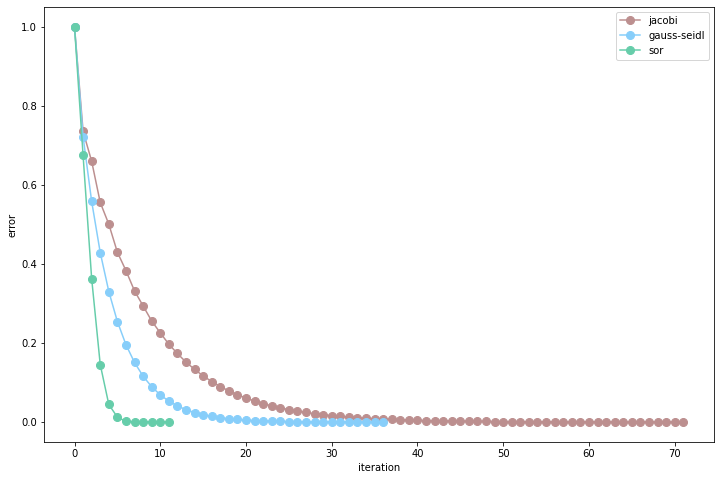

In [205]:
plot_iteration_error(A2, B2, x02, exact2, omega2)

wyniki:
...

## 2. Analiza obwodu elektrycznego

<i> Wykorzystaj dowolną z powyższych metod do wyliczenia natężenia prądu w każdej z części obwodu elektrycznego. </i>

<i>a) Stwórz funkcję tworzącą graf opisujący obwód elektryczny. Argumentami tej funkcji

* Lista krawędzi grafu ważonego gdzie wagi krawędzi określają opór fragmentu obwodu między dwoma węzłami. Wierzchołki grafu identyfikowane są przez liczby naturalne.
* Trójka liczb (s, t, E), przy czym para (s, t) wskazuje między którymi węzłami sieci przyłożono siłę elektromotoryczną E. Opór wewnętrzny SEM można zaniedbać. </i>

In [206]:
def create_circuit(resistors, emf):
    g = nx.DiGraph()
    
    for a, b, resistance in resistors:
        g.add_edge(a, b, weight=resistance)
        
    a, b, weight = emf
    if (a, b) not in g.edges() and (b, a) not in g.edges():
        g.add_edge(a, b)
    
    return g

In [207]:
def draw_graph(g):
    pos=nx.circular_layout(g)
    nx.draw_networkx(g, pos, with_labels=True)
    labels = nx.get_edge_attributes(g, 'weight')
    nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

<i>b) Napisz funkcję, która wykorzystując prawa Kirchhoffa znajdzie natężenia prądu w każdej części obwodu i przedstawi je na rysunku w postaci grafu ważonego z etykietami. </i>

In [215]:
def get_amperage(g, a, b, voltage, exact=None):
    n = g.number_of_edges()
    A = np.zeros((n, n))
    B = np.zeros(n)
    
    row = 0
    edges = {x: i for i, x in enumerate(g.edges())}
    
    # Drugie Prawo Kirchhoffa
    for cycle in nx.cycle_basis(g.to_undirected()):
        for j in range(len(cycle)):
            v1, v2 = cycle[j-1], cycle[j]
            if (v1, v2) == (a, b):
                B[row] = voltage
            elif (v1, v2) == (b, a):
                B[row] = -voltage
                
            if (v1, v2) in edges:
                A[row][edges[v1, v2]] = g[v1][v2]['weight']
            else:
                A[row][edges[v2, v1]] = -g[v2][v1]['weight']
        row += 1
    
    rows_start = row
        
    # Pierwsze Prawo Kirchhoffa
    for row in range(rows_start, n):
        v1 = row - rows_start
        for v2 in g[v1]:
            A[row][edges[v1, v2]] = 1
        for v2, _ in g.in_edges(v1):
            A[row][edges[v2, v1]] = -1
    

    if exact is None:
        exact = np.linalg.solve(A, B)
    
    x = gauss_seidl(A, B, np.zeros(len(edges)), exact, precision=0.5)
    new_graph = nx.DiGraph()
    
    for edge, i in edges.items():
        a, b = (edge[0], edge[1]) if x[i] > 0 else (edge[1], edge[0])
        new_graph.add_edge(a, b, weight=abs(x[i]))
    
    return new_graph

<i>c) Przetestuj działanie metody dla obwodu przedstawionego na Rysunku 1, wiedząc, że poprawne rozwiązanie to $x_1 = 26.5, x_2 = 9.35, x_3 = 13.3, x_4 = 6.13$ </i>

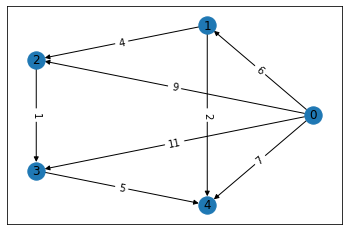

In [216]:
resistors = [(0, 1, 6), (0, 2, 9), (0, 3, 11), (0, 4, 7), 
             (1, 2, 4), (1, 4, 2), (2, 3, 1), (3, 4, 5)]
emf = (0, 4, 300)

g = create_circuit(resistors, emf)
draw_graph(g)

In [217]:
result_graph = get_amperage(g, *emf)
draw_graph(result_graph)

[[  6.   0.   0.  -7.   0.   2.   0.   0.]
 [  0.   9. -11.   0.   0.   0.   1.   0.]
 [  0.   0.  11.  -7.   0.   0.   0.   5.]
 [  1.   1.   1.   1.   0.   0.   0.   0.]
 [  6.  -9.   0.   0.   4.   0.   0.   0.]
 [ -1.   0.   0.   0.   1.   1.   0.   0.]
 [  0.  -1.   0.   0.  -1.   0.   1.   0.]
 [  0.   0.  -1.   0.   0.   0.  -1.   1.]]
[-300.    0. -300.    0.    0.    0.    0.    0.]
[[ 6.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  9.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 11.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  0.  0.  0.]
 [ 6. -9.  0.  0.  4.  0.  0.  0.]
 [-1.  0.  0.  0.  1.  1.  0.  0.]
 [ 0. -1.  0.  0. -1.  0.  1.  0.]
 [ 0.  0. -1.  0.  0.  0. -1.  1.]]
10.847042694868781
53.73958444610618
155.28245412138693
264.5148750212418
275.28051067936974
237.61424458206096
671.6448794033787
2458.213682072749
5678.651237660185
8860.870851307434
10197.1419461004
13673.83905797251
36991.380631874374
102664.47752469269
208466.72572911848
313127.61374682933
415797.00135026005
706295.216

<ipython-input-212-eb496941ad9e>:22: RuntimeWarning: overflow encountered in matmul
  x  = M @ x + W
<ipython-input-212-eb496941ad9e>:22: RuntimeWarning: invalid value encountered in matmul
  x  = M @ x + W


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


Exception: iterations limit exceeded

<i>d) Przedstaw (wizualizacja oraz sprawdzenie poprawności wyników) działanie programu dla grafów spójnych mających od 15 do 100 wierzchołków:
* Spójny graf losowy
* Graf 3-regularny (kubiczny)
* Graf złożony z dwóch grafów losowych połączonych mostkiem
* Graf siatka 2D </i>

## Wnioski

 - 
 - 
 -

M. Hawryluk 29.04.2021